# Street View House Numbers
### Outline:
Multi-class classfication problem where images are crops(32x32x3) from google street view style imaging. The goal of the classification is to determine which number is in the image (0-9)(except label y==10 is in reality the number 0). Images are RGB, often blurred or with significant skew.
In this notebook I train set of basic models to attempt to solve this task.
MZ2022

1 - Imports
+ static random_seed
+ set pytorch 'device'

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torchmetrics import F1Score, ConfusionMatrix, MatthewsCorrCoef
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import datetime
import time

device = "cpu"
if (torch.cuda.is_available()):
    device = "cuda"
print('Compute device in use:', device)

torch.manual_seed(19)

Compute device in use: cpu


2 - Data
+ load data
+ svhn_dataset class
+ define Transforms used in data_augmentation
+ visual augmentation sanity check
+ train/validation split
+ create dataloaders

In [2]:
path_to_data = 'data/train_32x32.mat'
original_data = scipy.io.loadmat(file_name=path_to_data)

#Strip the matlab-generated metadata
dataset_X = original_data['X']
dataset_y = original_data['y']

#replace label y==10 --> 0 convention
dataset_y[dataset_y==10] = 0

num_examples = dataset_y.size
print(f'The training_data package contains {num_examples} examples.')
print(f'The original shape of the dataset is: X:{dataset_X.shape} and y: {dataset_y.shape}')
print(f'Labels: {np.unique(dataset_y)}')

# reshape X into NCHW from HWCN. pytorch like NCHW for transforms
dataset_X = np.transpose(dataset_X, axes=(3,0,1,2)) # NHWC
#dataset_X = np.transpose(dataset_X, axes=(3,2,0,1)) #NCHW

print(f'The shape of the dataset is: X:{dataset_X.shape} and y: {dataset_y.shape}')

The training_data package contains 73257 examples.
The original shape of the dataset is: X:(32, 32, 3, 73257) and y: (73257, 1)
Labels: [0 1 2 3 4 5 6 7 8 9]
The shape of the dataset is: X:(73257, 32, 32, 3) and y: (73257, 1)


In [3]:
## make a callable dataset using pytorch tools that interfaces with Dataloader and Transforms
class svhn_dataset():
    """ pytorch-friendly dataset class for svhn
    """
    def __init__(self, X, y, transforms = None):
        self.X = X
        self.y = y.squeeze() 
        self.transforms = transforms

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        #convert to PIL image for transforms
        image = Image.fromarray(self.X[index,...])
        label = self.y[index]

        if self.transforms is not None:
            image = self.transforms(image)
        
        return image, int(label)


In [4]:
# Define augmentation transforms that would be relevant and useful
# no flips L/R or U/D because that isn't realistic for this problem
aug_prob = 0.5
image_transforms = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomAffine(degrees=25, translate=(0, 0.2)), #25deg max rotate, max translation +/- 20%
        transforms.ColorJitter(brightness=0.25, contrast=0.25), #25% brightness, contrast changes.
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=aug_prob)
    ],
    p=aug_prob),
    transforms.ToTensor(), #get to pytorch tensor from PIL image
]) 

In [14]:
# Create training and validation datasets
# stratified split 70/30
train_validation_split = 0.7
X_train, X_validation, y_train, y_validation = train_test_split(dataset_X,
                                                                dataset_y,
                                                                train_size=train_validation_split,
                                                                stratify=dataset_y)

print(f'The training dataset has the following shape: {X_train.shape}')
print(f'The validation dataset has the following shape: {X_validation.shape}')

training_dataset = svhn_dataset(X=X_train, y=y_train, transforms=image_transforms)
validation_dataset = svhn_dataset(X=X_validation, y=y_validation, transforms=image_transforms)


The training dataset has the following shape: (51279, 32, 32, 3)
The validation dataset has the following shape: (21978, 32, 32, 3)


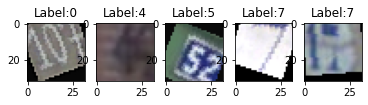

In [15]:
# perform a visual sanity check on the transformations, to ensure they are being applied. 
fig = plt.figure()
for r in range(0,5):
    image, label = training_dataset.__getitem__(index=np.random.randint(low=0,high=training_dataset.__len__()))
    plt.subplot(1,5,r+1)
    plt.imshow(image.permute(1,2,0)) #get back from pytorch ordering to something plt likes
    plt.title(f'Label:{label}')

In [7]:
def create_DataLoaders(training_dataset, validation_dataset, batch_size, shuffle):
    """Create DataLoader objects for training and validation datasets 

    Args:
        training_dataset (iterable dataset): iterable dataset for training data
        validation_dataset (iterable dataset): iterable dataset for validation data
        batch_size (_type_): number of examples in a batch
        shuffle (_type_): random order in batch or not

    Returns:
        training_loader: dataloader for Training set
        validation_loader: dataloader for validation set
    """

    # add multiprocessing?
    training_loader = torch.utils.data.DataLoader(dataset=training_dataset,
        batch_size=batch_size,
        shuffle=shuffle
    )

    validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
    batch_size=batch_size,
    shuffle=shuffle
    )

    return training_loader, validation_loader


#3 - Model, Model Parameters, Loss, Optimizer
+ CNN
+ define training and validation loop functions

In [8]:
# deep CNN. Lets do (input)-(3x(conv,pool,drop)layers)-(dense_out)
class cnn(nn.Module):
    """
        Define cnn model for SVHN
    """
    def __init__(self, input_size, num_layers, n_feat_l1=16, num_classes=10, RGB=True, dropout_probability=0.2, kernel_size=3, stride=1, pad=1):
        
        super(cnn, self).__init__()
        # variables
        self.input_size = input_size
        self.num_layers = num_layers
        self.n_feat_l1 = n_feat_l1
        self.num_classes = num_classes
        self.dropout_probability = dropout_probability
        self.kernel_size = kernel_size
        self.stride = stride
        self.pad = pad
        if RGB:
            input_channels=3
        else:
            input_channels=1

        #define model layers
        self.in_features = np.arange(self.n_feat_l1,self.n_feat_l1*(2+self.num_layers), self.n_feat_l1)

        self.input_layer = nn.Conv2d(in_channels=input_channels,
            out_channels=n_feat_l1,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.pad)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.drop = nn.Dropout2d(p=self.dropout_probability)

        self.fc = nn.Linear(int(self.in_features[-1]*(self.input_size[0]/2**self.num_layers)), out_features=num_classes)

        self.sequence = nn.Sequential()
        for l in range(self.num_layers):
            new = nn.Sequential(
                nn.Conv2d(in_channels=self.in_features[l],
                    out_channels=self.in_features[l+1],
                    kernel_size=self.kernel_size,
                    stride=self.stride,
                    padding=self.pad),
                nn.MaxPool2d(kernel_size=2), 
                nn.Dropout2d(p=dropout_probability),
                nn.ReLU()
            )
            self.sequence.append(new)
        
    def forward(self,x):

        x = F.relu(self.pool2(self.input_layer(x)))
        x = self.sequence(x)
        x = x.view(-1, int(self.in_features[-1]*(self.input_size[0]/2**self.num_layers))) #flatten before fc
        x = self.fc(x)
        x = F.log_softmax(x,dim=1)

        return x


In [9]:
def train(model, device, training_loader, optimizer, loss_metric):
    """Training Loop

    Args:
        model (_type_): pytorch model
        device (_type_): target device
        training_loader (_type_): data loader
        optimizer (_type_): Optimizer object
        loss_metric (_type_): loss metric object

    Returns:
        training_loss(tensor): training_loss
    """
    model.train()
    training_loss = 0

    for batch_index, (batch_images, batch_labels) in enumerate(training_loader):
        optimizer.zero_grad()
        
        batch_images = batch_images.to(device=device)
        batch_labels = batch_labels.to(device=device)

        output = model(batch_images)

        loss = loss_metric(output, batch_labels)

        training_loss += loss.item()

        #backprop
        loss.backward()
        optimizer.step()

    training_loss = training_loss/(batch_index+1)

    return training_loss

In [10]:
def validate(model, device, validation_loader, loss_metric):
    """Validate Loop

    Args:
        model (_type_): pytorch model
        device (_type_): target device
        validation_loader (_type_): data loader
        loss_metric (_type_): loss metric object

    Returns:
        validation_loss(tensor): float  
        metrics(dict): dict of performance metrics
    """
    mcc_score = MatthewsCorrCoef(num_classes=model.num_classes)
    confmatrix = ConfusionMatrix(num_classes=model.num_classes, normalize='true')
    model.eval()
    validation_loss = 0
    accuracy = 0
    mcc = 0
    cm = 0
    metrics={}

    with torch.no_grad():
        for batch_index, (batch_images, batch_labels) in enumerate(validation_loader):

            batch_images = batch_images.to(device=device)
            batch_labels = batch_labels.to(device=device)
            
            output = model(batch_images)

            validation_loss += loss_metric(output, batch_labels).item()

            # get predicted labels 
            _, predicted_labels = torch.max(output.data, 1)

            batch_accuracy = torch.sum(predicted_labels == batch_labels)/len(predicted_labels)
            mcc += mcc_score(predicted_labels, batch_labels)
            cm += confmatrix(predicted_labels, batch_labels)
            accuracy += batch_accuracy

    metrics["mcc"] = (mcc/(batch_index+1))
    metrics["accuracy"] = accuracy/(batch_index+1)
    metrics["cm"] = cm/(batch_index+1)

    validation_loss = validation_loss/(batch_index+1)

    return validation_loss, metrics

#4 - Training + Validation Loops
+ initialize dataloaders
+ initalize model
+ intialize optimizer, loss, metric tracking arrays, datestamp for model io

--> upgrade by paramaterizing this to set up for automated hyperparam tuning/sweeps

In [11]:
# dataloaders
batch_size = 128
training_loader, validation_loader = create_DataLoaders(training_dataset, validation_dataset, batch_size=batch_size, shuffle=True)

# Create Model
model = cnn(input_size=(32,32),num_layers=3,n_feat_l1=32, num_classes=10)
# print(model)

# Parameters
init_lr = 1e-3
optimizer = torch.optim.Adam(params=model.parameters(), lr=init_lr)
loss_metric = nn.CrossEntropyLoss()

num_epochs = 30

# metric tracking. intitalize some arrays
epoch_number = []
training_loss = []
validation_loss = []
accuracy = []
mcc = []
cm=[]

best_model = []
best_n_models = 2 # how many models do you want to hold onto

# Training-Start datestamp
date = datetime.datetime.now()

print(f'Training for {num_epochs} epochs.')
for epoch in tqdm(range(num_epochs)):

    tqdm.write(str(f'Epoch: : {epoch}'))
    
    e_train_loss = train(model, device, training_loader, optimizer, loss_metric)
    e_val_loss, metrics = validate(model, device, validation_loader, loss_metric)

    # metrics
    training_loss.append(e_train_loss)
    validation_loss.append(e_val_loss)
    accuracy.append(metrics['accuracy'])
    mcc.append(metrics['mcc'])
    cm.append(metrics['cm'])

    #console-prints (could swap to mlflow/tensorboard for cleaner multi-model tracking and live-results)
    tqdm.write(str(f'Training Loss: {e_train_loss:.5f}'))
    tqdm.write(str(f'Validation Loss: {e_val_loss:.5f}'))
    tqdm.write(str(f'Validation Accuracy: {metrics["accuracy"]:.5f}'))
    tqdm.write(str(f'Validation MCC: {metrics["mcc"]:.5f}'))

    # early stopping logic would go here

    # Save model if min validation loss + max f1
    if (np.min(validation_loss) == e_val_loss) and (np.max(mcc) == metrics["mcc"]):
        datestamp = datetime.datetime.strftime(date, format='%Y_%m_%d_%H%M')
        path_to_model=f'models/svhn_model_{datestamp}_e{epoch}.pt'
        torch.save(model.state_dict(),path_to_model)
        tqdm.write(str(f'Saved new best model: {path_to_model}'))

        best_model.append(path_to_model) #add to best list
        if len(best_model) > best_n_models:
            os.remove(path=best_model[0]) #delete previous best model
            best_model.pop(0) #left shift list by popping first index

cnn(
  (input_layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=10, bias=True)
  (sequence): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Dropout2d(p=0.2, inplace=False)
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Dropout2d(p=0.2, inplace=False)
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): D

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: : 0


  3%|▎         | 1/30 [01:52<54:16, 112.29s/it]

Training Loss: 2.02536
Validation Loss: 1.31249
Validation Accuracy: 0.57839
Validation MCC: 0.52295
Saved new best model: models/svhn_model_2022_09_19_1302_e0.pt
Epoch: : 1


  7%|▋         | 2/30 [03:53<54:56, 117.73s/it]

Training Loss: 1.03157
Validation Loss: 0.73747
Validation Accuracy: 0.77355
Validation MCC: 0.74490
Saved new best model: models/svhn_model_2022_09_19_1302_e1.pt
Epoch: : 2


 10%|█         | 3/30 [05:54<53:37, 119.15s/it]

Training Loss: 0.74362
Validation Loss: 0.56906
Validation Accuracy: 0.82335
Validation MCC: 0.80053
Saved new best model: models/svhn_model_2022_09_19_1302_e2.pt
Epoch: : 3


 13%|█▎        | 4/30 [07:49<50:55, 117.51s/it]

Training Loss: 0.63804
Validation Loss: 0.50972
Validation Accuracy: 0.84244
Validation MCC: 0.82197
Saved new best model: models/svhn_model_2022_09_19_1302_e3.pt
Epoch: : 4


 17%|█▋        | 5/30 [09:40<47:58, 115.15s/it]

Training Loss: 0.58270
Validation Loss: 0.47315
Validation Accuracy: 0.85746
Validation MCC: 0.83895
Saved new best model: models/svhn_model_2022_09_19_1302_e4.pt
Epoch: : 5


 20%|██        | 6/30 [11:22<44:15, 110.64s/it]

Training Loss: 0.54246
Validation Loss: 0.45618
Validation Accuracy: 0.86149
Validation MCC: 0.84350
Saved new best model: models/svhn_model_2022_09_19_1302_e5.pt
Epoch: : 6


 23%|██▎       | 7/30 [13:26<44:06, 115.08s/it]

Training Loss: 0.51869
Validation Loss: 0.43717
Validation Accuracy: 0.86461
Validation MCC: 0.84715
Saved new best model: models/svhn_model_2022_09_19_1302_e6.pt
Epoch: : 7


 27%|██▋       | 8/30 [15:27<42:48, 116.77s/it]

Training Loss: 0.49528
Validation Loss: 0.41697
Validation Accuracy: 0.87705
Validation MCC: 0.86120
Saved new best model: models/svhn_model_2022_09_19_1302_e7.pt
Epoch: : 8


 30%|███       | 9/30 [17:25<41:05, 117.39s/it]

Training Loss: 0.47857
Validation Loss: 0.39461
Validation Accuracy: 0.88102
Validation MCC: 0.86560
Saved new best model: models/svhn_model_2022_09_19_1302_e8.pt
Epoch: : 9


 33%|███▎      | 10/30 [19:29<39:43, 119.18s/it]

Training Loss: 0.46734
Validation Loss: 0.39321
Validation Accuracy: 0.88067
Validation MCC: 0.86529
Epoch: : 10


 37%|███▋      | 11/30 [21:38<38:42, 122.22s/it]

Training Loss: 0.45335
Validation Loss: 0.37855
Validation Accuracy: 0.88361
Validation MCC: 0.86863
Saved new best model: models/svhn_model_2022_09_19_1302_e10.pt
Epoch: : 11


 40%|████      | 12/30 [24:01<38:34, 128.60s/it]

Training Loss: 0.43638
Validation Loss: 0.37743
Validation Accuracy: 0.88836
Validation MCC: 0.87391
Saved new best model: models/svhn_model_2022_09_19_1302_e11.pt
Epoch: : 12


 43%|████▎     | 13/30 [26:02<35:48, 126.39s/it]

Training Loss: 0.43871
Validation Loss: 0.37684
Validation Accuracy: 0.88517
Validation MCC: 0.87045
Epoch: : 13


 47%|████▋     | 14/30 [28:06<33:28, 125.55s/it]

Training Loss: 0.43282
Validation Loss: 0.37914
Validation Accuracy: 0.88598
Validation MCC: 0.87130
Epoch: : 14


 50%|█████     | 15/30 [30:44<33:53, 135.54s/it]

Training Loss: 0.42207
Validation Loss: 0.35643
Validation Accuracy: 0.89232
Validation MCC: 0.87849
Saved new best model: models/svhn_model_2022_09_19_1302_e14.pt
Epoch: : 15


 53%|█████▎    | 16/30 [32:49<30:51, 132.23s/it]

Training Loss: 0.41421
Validation Loss: 0.35098
Validation Accuracy: 0.89641
Validation MCC: 0.88302
Saved new best model: models/svhn_model_2022_09_19_1302_e15.pt
Epoch: : 16


c:\Users\maziegle\AppData\Local\Programs\Python\Python39\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: 10 nan values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
 57%|█████▋    | 17/30 [35:03<28:45, 132.75s/it]

Training Loss: 0.40667
Validation Loss: 0.34555
Validation Accuracy: 0.89705
Validation MCC: 0.88360
Saved new best model: models/svhn_model_2022_09_19_1302_e16.pt
Epoch: : 17


 60%|██████    | 18/30 [37:11<26:15, 131.30s/it]

Training Loss: 0.40135
Validation Loss: 0.34535
Validation Accuracy: 0.89737
Validation MCC: 0.88416
Saved new best model: models/svhn_model_2022_09_19_1302_e17.pt
Epoch: : 18


 63%|██████▎   | 19/30 [39:29<24:25, 133.23s/it]

Training Loss: 0.40087
Validation Loss: 0.33951
Validation Accuracy: 0.89981
Validation MCC: 0.88683
Saved new best model: models/svhn_model_2022_09_19_1302_e18.pt
Epoch: : 19


 67%|██████▋   | 20/30 [41:48<22:30, 135.07s/it]

Training Loss: 0.39104
Validation Loss: 0.33665
Validation Accuracy: 0.90101
Validation MCC: 0.88820
Saved new best model: models/svhn_model_2022_09_19_1302_e19.pt
Epoch: : 20


 70%|███████   | 21/30 [43:49<19:37, 130.82s/it]

Training Loss: 0.39250
Validation Loss: 0.33222
Validation Accuracy: 0.90228
Validation MCC: 0.88959
Saved new best model: models/svhn_model_2022_09_19_1302_e20.pt
Epoch: : 21


 73%|███████▎  | 22/30 [45:46<16:53, 126.74s/it]

Training Loss: 0.39007
Validation Loss: 0.32786
Validation Accuracy: 0.90399
Validation MCC: 0.89154
Saved new best model: models/svhn_model_2022_09_19_1302_e21.pt
Epoch: : 22


 77%|███████▋  | 23/30 [47:29<13:57, 119.65s/it]

Training Loss: 0.38211
Validation Loss: 0.33391
Validation Accuracy: 0.90169
Validation MCC: 0.88894
Epoch: : 23


 80%|████████  | 24/30 [49:32<12:03, 120.60s/it]

Training Loss: 0.38206
Validation Loss: 0.32225
Validation Accuracy: 0.90355
Validation MCC: 0.89110
Epoch: : 24


 83%|████████▎ | 25/30 [52:01<10:45, 129.01s/it]

Training Loss: 0.37828
Validation Loss: 0.33152
Validation Accuracy: 0.90216
Validation MCC: 0.88958
Epoch: : 25


 87%|████████▋ | 26/30 [53:42<08:02, 120.72s/it]

Training Loss: 0.37774
Validation Loss: 0.31912
Validation Accuracy: 0.90704
Validation MCC: 0.89502
Saved new best model: models/svhn_model_2022_09_19_1302_e25.pt
Epoch: : 26


 90%|█████████ | 27/30 [55:25<05:45, 115.28s/it]

Training Loss: 0.37034
Validation Loss: 0.31897
Validation Accuracy: 0.90571
Validation MCC: 0.89354
Epoch: : 27


 93%|█████████▎| 28/30 [57:28<03:55, 117.57s/it]

Training Loss: 0.37258
Validation Loss: 0.31893
Validation Accuracy: 0.90730
Validation MCC: 0.89520
Saved new best model: models/svhn_model_2022_09_19_1302_e27.pt
Epoch: : 28


 97%|█████████▋| 29/30 [59:52<02:05, 125.48s/it]

Training Loss: 0.36888
Validation Loss: 0.32185
Validation Accuracy: 0.90534
Validation MCC: 0.89312
Epoch: : 29


100%|██████████| 30/30 [1:01:28<00:00, 122.95s/it]

Training Loss: 0.36446
Validation Loss: 0.31321
Validation Accuracy: 0.90725
Validation MCC: 0.89526
Saved new best model: models/svhn_model_2022_09_19_1302_e29.pt


#5 - Visualize Training and Validation Results
+ Loss curves
+ Performance Metric curves
+ Confusion matrix 

Text(0, 0.5, 'actual')

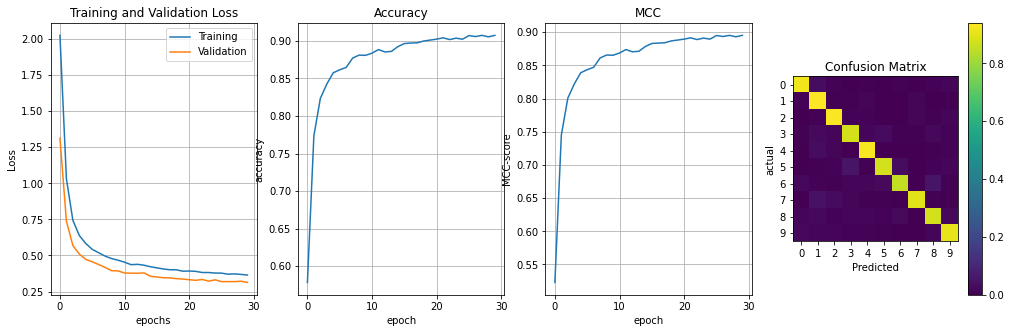

In [12]:
figure = plt.figure(figsize=(17,5))

# Loss Curves
plt.subplot(1,4,1)
plt.plot(training_loss)
plt.plot(validation_loss)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.legend(["Training", "Validation"])
plt.grid(visible=True)

# Accuracy Curve
plt.subplot(1,4,2)
plt.plot(accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(visible=True)
plt.title('Accuracy')

# Matthews Correlation Coeff Curve
plt.subplot(1,4,3)
plt.plot(mcc)
plt.xlabel('epoch')
plt.ylabel('MCC-score')
plt.grid(visible=True)
plt.title('MCC')

# Confusion Matrix
plt.subplot(1,4,4)
plt.imshow(cm[-1].numpy())
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(ticks=np.arange(0,model.num_classes), labels=np.arange(0,model.num_classes))
plt.yticks(ticks=np.arange(0,model.num_classes), labels=np.arange(0,model.num_classes))
plt.xlabel('Predicted')
plt.ylabel('actual')